# Kortdage 2025 - Introduktion til Python - Raster

## Hvorfor arbejde med raster? 
Raster giver nogle andre muligheder end vektordata, da man typisk kan få dækket større arealer på én gang og danne grundlag for fx bydækkende eller landsdækkende datasæt. 
Man kan fx bruge den nationale højdemodel til at lave klimatilpasningsanalyser, finde højde på bygninger og klassificere ortofotos.

I dag findes der en masse gratis og offentlig tilgængelige rasterdata, specielt i form af satellitbilleder. Både ESA og NASA udstiller mange af deres produkter gratis og de kan med relativt simple analyser bruges i den offentlige forvaltning. KDS har også en del rasterprodukter, der udstiller frit, fx højdemodellen og ortofotos.

I disse øvelser bliver der anvendt et billede fra en af NASA's Landsat satellitter. Landsat-missionen har eksisteret siden 1970'erne og er bredt anvendt i forskning og offentlig forvaltning. Vi skal bruge data på overfladetemperaturer, for at vise et eksempel på, hvordan overfladetemperaturerne i en dansk by varierer. 

I øvelserne bliver der taget udgangspunkt i overfladetemperaturer i Nykøbing Falster. Der anvendes to datasæt, et rasterbillede med overfladetemperaturer og nogle af afstemningsområderne fra området. Afstemningsområderne bliver brugt til at vise, hvordan man kan kombinere raster og vektordata. Overfladetemperaturerne er fra en tilfældig sommerdag og de skal blot ses som et eksempel på rasterdata, da der ikke er lavet kvalitetstjek af data.

Vi skal igennem fem øvelser: 
1. Indlæsning af raster og vektordata samt simple plots
2. Undersøgelse af gennemsnitsoverfladetemperaturen i nogle administrative områder
3. Indeksering af raster 
4. Udpegning af de varmeste områder
5. Eksport af data

For at give jer lidt inspiration og præsentere jer for nogle af de muligheder, der er for at arbejde med raster i Python, indeholder denne del af workshoppen ikke så mange 'gør det selv'-opgaver. Læringskurven er ret stejl, men det kan forhåbentlig give jer lidt blod på tanden.

Der er enormt mange måder at arbejde med data i Python og her bliver der kun præsenteret et par stykker. Denne del af workshoppen vil være præget af, at det er Julie, der har lavet eksemplerne. Måden koden er skrevet på, kommentarerne, de anvendte biblioteker mm vil være én måde at gøre det på og ikke nødvendigvis den mest effektive eller overskuelige for andre. 
Det handler i høj grad om at finde sin egen stil og en måde at kode på, der passer til ens eget temperament. 

Hvis der er noget, der ikke giver mening, skal I endelig ikke holde jer tilbage med at spørge. 

NB: Indentation er vigtigt i python. Nogle funktioner kræver, at nogle linjer er indenteret.  


Der kan hentes yderligere inspiration og hjælp fra bl.a. disse sider: 
* [Earth Data Science - generel intro til raster](https://earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/)
* [Geo Hack Week - eksempler på arbejde med Landsat billeder](https://geohackweek.github.io/raster/04-workingwithrasters/)
* [Google Earth Engine - gratis for non-kommercielle kunder ](https://earthengine.google.com/)


Information og dokumentation af typisk anvendte biblioteker til raster: 
* [Rasterio](https://rasterio.readthedocs.io/en/stable/)
* [Numpy](https://numpy.org/)
* [GDAL, som også findes i QGIS](https://gdal.org/en/stable/)




### Øvelse 1 - import af data 
Installation af libraries. Nogle af de libraries, der anvendes, når man arbejder med raster er ikke så gængse i Python-verdenen. 
Det mest anvendte er rasterio, men numpy kan også bruges til at løse mange opgaver. Det er også muligt at arbejde med GDAL, som også findes i QGIS. 

In [ ]:
!pip install geopandas
!pip install pandas
!pip install rasterio
!pip install rasterstats
!pip install owslib
!pip install matplotlib

Indlæsning af libraries. Når libraries er installeret skal de indlæses, så de kan anvendes i scriptet. 

Bemærk at flere af dem indlæses med et alias (fx import geopandas as gpd). Det gøres, for at slippe for at skrive hele navnet, når man skal kalde en funktion. 

In [ ]:
import geopandas as gpd
import pandas as pd

import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import plotting_extent


from rasterstats import zonal_stats
from datetime import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.colors as colors

**Indlæsning af data**

Til opgaven skal der anvendes et rasterbillede og noget vektordata. 
Rasterdata kan indlæses på flere måder. Rasterio har en relativ simpel 'open' funktion, hvor båndene i en rasterfil kan indlæses ét af gangen eller flere på samme tid. 
I dette tilfælde har rasterfilen kun et bånd og det indlæses i variablen 'uhiraster' ved at bruge stien til billedet.

Vektordata kan også indlæses på flere måder. I dette tilfælde anvendes Geopandas, som også blev anvendt i den første del af workshoppen. 
Vektordataen kommer fra en geopackage og bliver indlæst med geopandas funktionen 'read_file'. Der kan også indlæses data fra andre filformater, databaser og diverse web-services. 

In [2]:
# For at downloade vores input data til google colab kloner vi vores github repository 
if not os.path.exists('/content/python_kortdage'):

    ! git clone https://github.com/anerv/python_kortdage

else:
    print("Repository already cloned")

Cloning into 'python_kortdage'...


In [38]:
# Url til billedets placerin
inputuhi = r"python_kortdage\data\lst_nykoebing_f_2025_celcius.tif"

# Åbn billedet med rasterio. Læs bånd nr. 1 og definer datatypen som float.
with rasterio.open(inputuhi) as src:
    uhiraster = src.read(1)  # Læs det første bånd
    extent = plotting_extent(src)


# No-data værdien i dette billede er sat til en negativ værdi, så alle celler, der er under 0, sættes til No Data (her er et eksempel på, hvordan numpy kan bruges med rasterdata)
uhiraster[uhiraster < 0] = np.nan

# ***Indlæs vektordata ***
# Sti til geopackage defineres
url = r"python_kortdage\data\nykoebing_afstemningsomraader.gpkg"

# Geopandas bruges til at indlæse filen. Herefter defineres koordinatsystemet
admin_gr_gdf = gpd.read_file(url)
admin_gr_gdf = admin_gr_gdf.set_crs(epsg=25832, inplace=True, allow_override=True)

# For lige at tjekke at data ser ud som forventet, printes tabellen
admin_gr_gdf.head()

,id,navn,redigeringsret,dataspecifikation,landekode,skala,udtraeksdato,afstemningsomraadenummer,afstemningsstednavn,kommunekode,kommunelokalid,opstillingskredsnummer,geometry
0,dagi.701828,Sundby,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,07,Sundskolen,0376,389151,30,"MULTIPOLYGON (((680550.66 6073168.09, 680808.2..."
1,dagi.706380,Lindeskov,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,03,Østerbroskolen,0376,389151,30,"MULTIPOLYGON (((684956.86 6071360.02, 684965.0..."
2,dagi.706386,Ejegod,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,04,Ejegodhallen,0376,389151,30,"MULTIPOLYGON (((679788.29 6076915.89, 679797.6..."
3,dagi.709646,Byen,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,01,Nykøbing F. Hallen,0376,389151,30,"MULTIPOLYGON (((683973.38 6073087.57, 683975 6..."
4,dagi.703554,Østerbro,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,02,Brydeklubben Thor,0376,389151,30,"MULTIPOLYGON (((684500.67 6071807.7, 684500.86..."


**Simpelt plot**

Der er endeløse muligheder for at plotte sit data. 

Herunder plotter vi både rasterbilledet og afstemningsområderne på en meget simpel måde. 
Det kan være smart med et simpelt plot, hvis man skal tjekke at data er indlæst korrekt. 

Når man skal plotte en geodataframe, kan man blot skrive navnet på geodataframen efterfulgt af .plot() og så bliver data automatisk plottet. 
Rasterbilledet bliver vist med rasteriopluginnets funktion 'imshow', der også kan bruges til at vise andre typer af billeder (fx png eller jpeg)

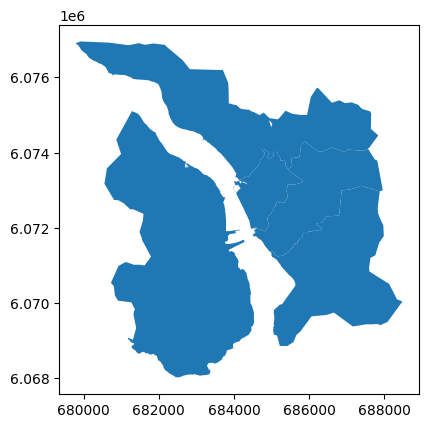

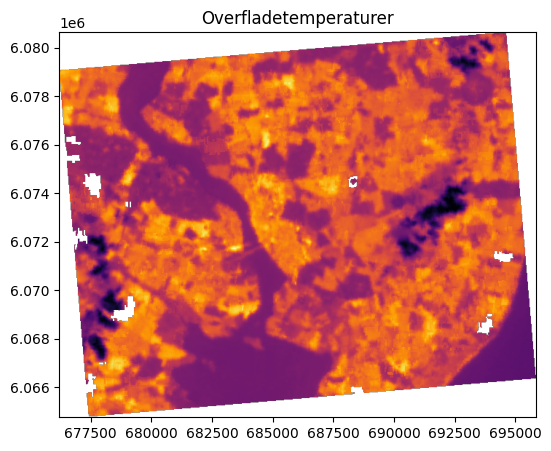

In [41]:
# Plot af afstemningsområderne
admin_gr_gdf.plot()

# Plot af rasterbilledet
fig, ax = plt.subplots(figsize=(10, 5))
chm_plot = ax.imshow(uhiraster, extent=extent, cmap='inferno')


ax.set_title("Overfladetemperaturer")
plt.show()

**Subplots**

En lidt pænere og strømlinet måde at plotte flere datasæt er ved at lave et subplot. 

Her kan man definere et grid, hvori man kan placere sine plots, så de har den samme størrelse, deler signaturforklaringer, akserne bliver ens mm. 

Det bliver lavet med matplotlib-biblioteket, som indeholder enormt mange muligheder, men det er godt dokumenteret og der findes masser af eksempler på brugen af det. 

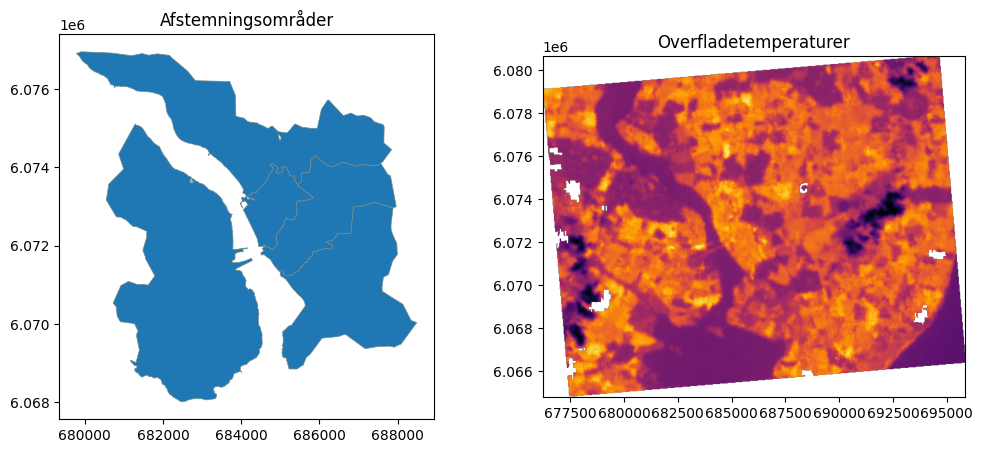

In [51]:
# Definer størrelse på subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot afstemningsområder
fig_afstemningsomr = admin_gr_gdf.plot(
    linewidth=0.5,              # Linewidth på outline
    edgecolor="#768c8a",      # Farve på outline
    ax=ax[0],                   # Definer hvilken akse/del af grid plottet skal være i 
)

# Definer overskrift
ax[0].set_title("Afstemningsområder")

# Plot rasterbilledet
chm_plot = ax[1].imshow(uhiraster, extent=extent, cmap='inferno') #ax[1] definerer placeringen i griddet

# Definer overskrift
ax[1].set_title("Overfladetemperaturer")

plt.show()

Det er også muligt at plotte afstemningsområderne og overfladetemperaturene i det samme plot, så man kan se områderne over billedet. 
Her skal begge datasæt plottes på den samme akse (ax) og man skal sørge for, at det datasæt, man gerne vil have øverst, bliver plottet til sidst 

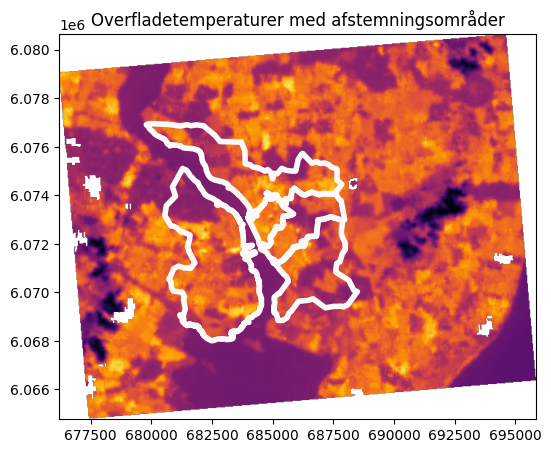

In [53]:
# Definer størrelse på subplot (her 1,1, da der kun er et plot)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot rasterbilledet
chm_plot = ax.imshow(uhiraster, extent=extent, cmap='inferno')

# Definer overskrift
ax.set_title("Overfladetemperaturer med afstemningsområder")

# Plot afstemningsområder
fig_afstemningsomr = admin_gr_gdf.plot(
    linewidth=4,                # Linewidth på outline
    facecolor="none",           # Ingen fyldfarve      
    edgecolor="#fafafa",      # Farve på outline
    ax=ax                  # Definer hvilken akse/del af grid plottet skal være i 
)

plt.show()

### Øvelse 2 - zonal statistics

Man kan rigtig meget med rasterbilleder i sig selv, men det er ofte brugbart at undersøge rasterværdierne inden for nogle definerede områder. 
Det gør det nemmere at præsentere data og fx bruge data til at lave indsatsområder eller undersøge udvikling over tid. 

Når data skal præsenteres for beslutningstagere er det også ofte nemmere at præsentere data inden for de samme grænser og det bliver nemmere at sammenligne resultater fra forskellige analyser. 

I dette eksempel skal vi finde gennemsnitsoverfladetemperaturen inden for afstemningsområderne vi har indlæst overfor. 
Hvis vi fx også undersøgte befæstelsesgraden eller vegetationsdækket inden for de samme områder, ville vi nemt kunne lave en grov sammenligning af disse parametre




**Zonal statistics**

Zonal statistics er en gængs måde at undersøge rasterværdier inden for polygoner. Funktionen findes også i de fleste GIS-programmer og er en nyttig måde at bringe de to datatyper sammen

I dette eksempel bruger vi et library, zonal_stats, som vi indlæste i toppen af scriptet. 

In [ ]:
# Kør funktionen med afstemningsområderne og overfladetemperaturerne. Bemærk, at indlæsningen af rasterfilen er direkte fra tif-filen
# Der kan laves forskellige aggregeringer (fx max-værdier, standardafvigelser mm). Her er vi kun interesseret i gennemsnittet.
zs_uhi_adminomraader = zonal_stats(
    admin_gr_gdf, inputuhi, stats="mean", geojson_out=True
)

# Resultatet af zonals stats er en geojson. For at vi nemmere kan arbejde videre med den, konverteres den til en geodataframe
gdf_uhi_adminomraader = gpd.GeoDataFrame.from_features(zs_uhi_adminomraader)

# Resultatet plottes. Resultaten af zonals er en tilføjet kolonne med værdien/værdierne, man har defineret i funktionen, så i dette tilfælde er der tilføjet et kolonne med 'mean'
gdf_uhi_adminomraader.head(2)

Øvelse: Prøv at få både gennemsnit og max-værdi i zonal statistics. 

Dokumentation kan ses her https://pythonhosted.org/rasterstats/

In [ ]:
# Kopier koden fra ovensående afsnit og prøv dig frem

In [ ]:
# Svaret kan også findes her:

zs_uhi_adminomraader_mean_max = zonal_stats(
    admin_gr_gdf, inputuhi, stats="mean max", geojson_out=True
)

gdf_uhi_adminomraader_mean_max = gpd.GeoDataFrame.from_features(
    zs_uhi_adminomraader_mean_max
)

#Print den øverste del af dataframen
gdf_uhi_adminomraader_mean_max.head(2)

**Plot gennemsnitsværdier inden for grænser**

Resultaterne plottes. Her kan der virkelig leges med farver, signaturforklaring mm 

In [ ]:
# Definer størrelse på figuren, som plottet skal være inde i
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

fig = gdf_uhi_adminomraader.plot(
    column="mean",  # Den kolonne, der skal farvelægges efter
    cmap="YlOrRd",  # Man kan bruge en af de mange prædefinerede farvepaletter eller evt. lave sin egen.
    # De prædefinerede kan ses her: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    linewidth=0.5,  # Linjebredde på polygonerne
    edgecolor="black",  # Farve på linjer. Her kan der også anvendes HEX-koder
    legend=True,  # True = der er signaturforklaring, False = ingen signaturforklaring
    ax=ax,  # Definerer hvilket subplot, plottet skal være i
    legend_kwds={
        "label": "°C",
        "shrink": 0.7,
    },  # Definerer parametre til signaturforklaringen.
    # Mulighederne kan ses her: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar
)

# Definer titel
ax.set_title("GNS overfladetemp", fontsize=14)

# Fjern akserne (koordinaterne i siden)
ax.axis("off")
plt.show()

Øvelse: lav et plot med visning af max-værdierne i stedet for mean. Husk, at vær opmærksom på navnet på geodataframen 

In [ ]:
# Kopier ovenstående plot og prøv dig frem. Du kan også prøve at skifte farvepaletten ud eller ændre i legendens opsætning

In [ ]:
# Svaret kan også findes her

# Definer størrelse på figuren, som plottet skal være inde i
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

fig = gdf_uhi_adminomraader_mean_max.plot(
    column="max",  # Den kolonne, der skal farvelægges efter
    cmap="turbo",  # Man kan bruge en af de mange prædefinerede farvepaletter eller evt. lave sin egen.
    # De prædefinerede kan ses her: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    linewidth=0.5,  # Linjebredde på polygonerne
    edgecolor="black",  # Farve på linjer. Her kan der også anvendes HEX-koder
    legend=True,  # True = der er signaturforklaring, False = ingen signaturforklaring
    ax=ax,  # Definerer hvilket subplot, plottet skal være i
    legend_kwds={
        "label": "°C",
        "shrink": 0.7,
    },  # Definerer parametre til signaturforklaringen.
    # Mulighederne kan ses her: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar
)

# Definer titel
ax.set_title("GNS overfladetemp", fontsize=14)

# Fjern akserne (koordinaterne i siden)
ax.axis("off")
plt.show()

### Øvelse 3 - Indeksering af raster 

Det kan ofte være en god idé at lave en indeksering af rasterværdier, for at gøre det nemmere at sammenligne med andre datsæt, hvor værdierne eller datatyperne er meget forskellige. 

Med indeksering menes der at reklassificere værdierne ind i nogle prædefinerede numeriske klasser. 

I dette eksempel vil vi gerne have fem klasser, hvor værdierne går fra 1-5 defineret ud fra minimum og maxværdierne i billedet. 
Denne reklassificering kan også laves på resultatet af zonal statistics, men i nogle tilfælde vil det være relevant at gøre det på selve billedet.

Man kan også lave en reklassificering ud fra nogle faste intervaller, man selv definerer manuelt eller automatisk 

Der er igen mange veje til rom. En af de nemmeste veje er at bruge librariet numpy til at definere antallet af klasser og lave inddelingen: 

In [ ]:
# Sørg for at det kun er celler der har en værdi, der kommer med. Der laves en 'maske' som lægges oven på billedet for kun af få de celler, der har en værdi. 
valid_mask = ~np.isnan(uhiraster)
valid_values = uhiraster[valid_mask]

# Definer antallet af klasser samt grænseværdierne for dem. Grænserne sættes ud fra mininum og maksimum værdierne i datasættet.
n_classes = 5
bins = np.linspace(np.nanmin(uhiraster), np.nanmax(uhiraster), n_classes + 1)

# Reklassificer vha klasserne defineret ovenfor
reclassified_uhi = np.zeros_like(uhiraster, dtype=int)
reclassified_uhi[valid_mask] = np.digitize(valid_values, bins, right=False)

Plot resultatet

In [ ]:
# Plot det reklassificerede
fig, ax = plt.subplots(figsize=(10, 5))

# Definer de farver, man gerne vil bruge til plottet. Der kan også anvendes en prædefineret
cmap = ListedColormap(["#3232a8", "#1eebda", "#eaf516", "#f58216", "#f51616"])

chm_plot = ax.imshow(reclassified_uhi, cmap=cmap)

ax.set_title("Reclassed uhi", fontsize=14)
ax.axis("off")
plt.show()

### Øvelse 4 - udpegning af de varmeste områder 
Man kan bruge resultatet af zonal statistics til at finde de varmeste områder, men hvis man er interesseret i at finde de varmeste områder uden de prædefinerede grænser, kan man arbejde med rasterbilledet i sig selv. 

En måde at gøre det på, er at bruge standardafvgielsen og gennemsnittet, til at finde de varmeste områder. Grænsen kan også være manuelt defineret, hvis man fx er interesseret i at finde alle områder, hvor overfladetemperaturen er over 40 grader. 

I dette eksempel vil vi kun have de varmeste områder inden for alle afstemningsområderne og ikke hele billedet i sig selv, så der anvendes zonal statistics for at finde gennemsnit og standardafvigelse inden for polygonet.

In [ ]:
# Grænserne mellem afstemningsområderne opløses, så der findes gns og std for hele området 
merged_omr = admin_gr_gdf[["id", "geometry"]].dissolve()

# Der bruges zonal statistics til at finde gennemsnittet og standardafvigelsen
uhi_std = zonal_stats(merged_omr, inputuhi, stats="mean std", geojson_out=True)

# For at trække gennemsnit og standardafvigelsen ud som tal, der kan bruges i en reklassificering, skal man trække tallene ud af en dictionary
mean_value = uhi_std[0]["properties"]["mean"]
std_value = uhi_std[0]["properties"]["std"]

# Grænsen for UHI defineres i dette eksempel som gennemsnit + (2x standardafvigelse)
uhi_graense = mean_value + (std_value * 2)

# Print grænsen
print("Grænsen for de varmeste områder er: ", round(uhi_graense, 1), "°C")

**Filtrering af billedet efter grænseværdien og plot**

For at visualisere de områder, hvor der er varmest, skal billedet med overfladetemperaturer reklassificeres, så alle celler under grænseværdien fjernes. 
I samme omgang klippes rasterbilledet, så det kun er celler inden for afstemningsområderne, der er med. 

Til reklassificeringen anvendes numpy.where, som minder om en case funktion 

In [ ]:
# Det originale rasterbillede åbnes, det klippes og herefter fjernes alle værdier under grænseværdien
with rasterio.open(inputuhi) as src:
    uhi_crs = src.crs

    # Klip billedet, så pixels uden for polygonerne er væk
    out_img, out_transform = mask(
        src, merged_omr.geometry, crop=True
    )  # Der klippes efter det mergede datasæt der blev lavet i tidligere afnsit

    # Fjern værdier under grænseværdien
    uhi = np.where(out_img[0] >= uhi_graense, 1, np.nan)

Plot af resultatet. Her anvendes matplotlib igen.

In [ ]:
# Plot resultatet og brug afstemningsområderne som en simpel baggrund
fig, ax = plt.subplots(figsize=(10, 5))

cmap = ListedColormap(["#352b2d"])
# Plot billede
show(uhi, transform=out_transform, cmap=cmap, ax=ax)

# Plot grænser
fig_afstemningsomr = admin_gr_gdf.boundary.plot(
    linewidth=0.5, edgecolor="#768c8a", ax=ax
)

plt.show()

### Øvelse 5 - Eksport af data

Data kan eksporteres til mange formater. Typisk vil man eksportere dem til en tif-fil, hvis det er raster. 
Vektordatasæt kan også eksporteres til flere formater og kan nemt eksporteres til en database. 
Når man skal skrive med rasterio åbner man en fil i 'skrivemode' og putter billedet ind i den fil. 

In [ ]:
outputuhi = r"/content/sample_data/uhi_esterimeret.tif" # Stien er til sample_data mappen der findes ude i venstre side

# *** Eksport af rasterdata***
with rasterio.open(
    outputuhi,
    mode="w",
    height=uhi.shape[0],
    width=uhi.shape[1],
    driver="GTiff",
    count=1,
    dtype=uhi.dtype,
    crs=uhi_crs,
    transform=out_transform,
) as new_dataset:
    new_dataset.write(uhi, 1)

### Øvelse 6 - hent data fra en webservice 

Den sidste øvelse! Her skal vi hente et billede fra en webservice. Der er en del offentligt tilgængelige satellitbilleder, der er tilgængelige på webservices. NASA udstiller fx deres billeder i [GIBS](https://www.earthdata.nasa.gov/engage/open-data-services-software/earthdata-developer-portal/gibs-api). Der er en dokumentation af, hvordan man kan hente, søge og vise data fra webservicen [her](https://nasa-gibs.github.io/gibs-api-docs/python-usage/)


Billederne kan hentes gennem python ved at anvende biblioteket owslib, som vi installerer herunder. 


I dette eksempel henter vi et billede fra en af [MODIS](https://modis.gsfc.nasa.gov/) satellitterne. MODIS tager billeder hver dag stort set alle steder på jorden. Opløsningen på de forskellige bånd er ret grov (mellem 250 og 10 km), men de daglige billeder giver mulighed for at lave mange forskellige analyser. 

In [ ]:
# Installer owslib biblioteket
!pip install owslib

In [ ]:
from owslib.wms import WebMapService
from IPython.display import Image, display # Indbygget bibliotek til at vise billeder

# Connect til  GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.1.1')

# Konfigurer de ønskede parametre for at hente et MODIS Terra Corrected Reflectance billede
img = wms.getmap(layers=['MODIS_Terra_CorrectedReflectance_Bands721'],  # Lag
                 srs='epsg:4326',  # Kortprojektion (her er der et begrænset udvalg af projektioner)
                 bbox=(12,54.5,13,57),  # Bounds
                 size=(600, 600),  # Billedets størrelse i pixels
                 time='2018-06-03',  # Dato 
                 format='image/png',  # Format
                 transparent=True)  # Nodata transparency

# Gem billede lokalt (her i google colab)
path = r"/content/sample_data/MODIS_Terra_CorrectedReflectance_TrueColor.png"
out = open(path, 'wb')
out.write(img.read())
out.close()

# Vis billede
Image(path)

**Vil du lære mere? Se vores liste over kurser og bøger [HER](https://github.com/anerv/python_kortdage/blob/main/inspiration.md).**